In [1]:
import os
import pandas as pd
import json
import numpy as np
#!pip install python-dotenv
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
#from ipynb.fs.full.my_functions import factorial

In [3]:
import tweepy
import traceback

In [4]:
# import spacy
import torch

# #!pip install spacymoji
# from spacymoji import Emoji

from sklearn.utils import resample
# from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GroupShuffleSplit, train_test_split
# from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer

#!pip install transformers
from transformers import AutoModel, BertTokenizerFast

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

C:\Users\karli\.conda\envs\fnews\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def evaluation_summary(description, true_labels, predictions):
  print("Evaluation for: " + description)
  print(classification_report(true_labels, predictions,  digits=3, zero_division=0))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions))

# Import, Fix and Clean Data

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

#remove_col = ['threadid','tweetid','support', 'evidentiality', 'certainty', 'event']
remove_col = ['Unnamed: 0.1', 'Unnamed: 0', 'id', 'author_id', 'edit_history_tweet_ids', 'Unnamed: 0.2']

# Impute null values with None
def null_process(feature_df):
    col = 'text'
    feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df

# Removed unused clumns
def remove_unused_col(df,column_n=remove_col):
    df = df.drop(column_n,axis=1)
    return df

def remove_foreign_languages(df):
    df = df[df['lang'] == 'en']
    return df

def clean_dataset(df):
    # remove unused column
    df = remove_unused_col(df)
    # impute null values
    df = null_process(df)
    # remove all languages except English
    df = remove_foreign_languages(df)
    return df

# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)    
    return text

## Nltk Preprocessing includes:
# Stop words, Stemming and Lemmetization
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    text = ' '.join([word for word in wordlist if word not in stopwords_dict])
    text = [ps.stem(word) for word in wordlist if not word in stopwords_dict]
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Combine dataset classes
real_df = pd.read_csv("data/FakeNewsNet/dataset/pf_real.csv")
fake_df = pd.read_csv("data/FakeNewsNet/dataset/pf_fake.csv")
fake_df['true'] = False
real_df['true'] = True
df = pd.concat([fake_df, real_df])
df.reset_index()

#print(df.head())


# Fix imbalance
# https://elitedatascience.com/imbalanced-classes
# Separate majority and minority classes
df_majority = df[df.true==True]
df_minority = df[df.true==False]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_downsampled = df_downsampled.sample(frac=1, random_state=111019)

df_downsampled.reset_index(inplace=True)

data_df = df_downsampled.copy()

data_df['created_at'] = pd.to_datetime(data_df['created_at']) # str to datetime
data_df['created_at'] = data_df.apply(lambda row: row['created_at'].hour, axis=1) # get hour from datetime

data_df = clean_dataset(data_df)
data_df.reset_index(inplace=True)

print(data_df['lang'].value_counts())


# https://mccormickml.com/2021/06/29/combining-categorical-numerical-features-with-bert/#31-all-features-to-text
# This will hold all of the dataset samples, as strings.
sen_w_feats = []

# The labels for the samples.
labels = []

# Some of the reviews are missing either a "Title" or "Review Text", so we'll 
# replace the NaN values with empty string.
data_df = data_df.fillna("")

print('Combining features into strings...')

# text 	source 	created_at 	lang 
# description 	username 	verified 	name 	location

# For each of the samples...
#print(data_df.head())
print(len(data_df))
sen_w_feats = []
for index, row in data_df.iterrows():
    combined = ""
    
    combined += f"I created this Tweet at {row['created_at']} o'clock " + \
        f"in the {row['lang']} language and in {row['location']} " + \
        f"from {row['source']}. "
        
    verification_status = "verified" if row["verified"] else "not verified"
    combined += f"My name is {row['name']}, username is {row['username']} " + \
        f"and I am {verification_status}. "
    
    combined += f"I would describe myself as {row['description']}. "
    
    combined += f"I wrote: {row['text']} "
    
    # Add the combined text to the list.
    sen_w_feats.append(combined)

    # Also record the sample's label.
    #print(index)
    labels.append(data_df.iloc[index]['true'])

print('  DONE.')

print('Dataset contains {:,} samples.'.format(len(sen_w_feats)))



# Split train-test
# https://stackoverflow.com/questions/61337373/split-on-train-and-test-separating-by-group

# Update df to the downsampled one

X = data_df.drop(labels='true', axis=1)
y = data_df.true

#print(y.head())

# NLTK preprocessing - not necessary with BERT
#X['text'] = X.text.apply(nltk_preprocess)


# Split into train/val/test sets
# Technique gained from https://stackoverflow.com/questions/68152473/python-split-to-train-test-val-using-groupshufflesplit
# Start by splitting into train-val and test

gs_1 = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=111019)
train_val_ix, test_ix = next(gs_1.split(X, y, groups=X.article_id))

X_test = X.iloc[test_ix]
y_test = y.iloc[test_ix]

X_train_val = X.iloc[train_val_ix]
y_train_val = y.iloc[train_val_ix]

# Then split train-val into train and val (but reset index first)
X_train_val = X_train_val.reset_index(drop=True)
y_train_val = y_train_val.reset_index(drop=True)
gs_2 = GroupShuffleSplit(n_splits=1, train_size=0.9, random_state=111019)
train_ix, val_ix = next(gs_2.split(X_train_val, y_train_val, groups=X_train_val.article_id))

# Clean dataset, e.g., remove article_id column
X_train_val = X_train_val.drop('article_id', axis=1)
X_test = X_test.drop('article_id', axis=1)

X_train = X_train_val.iloc[train_ix]
y_train = y.iloc[train_ix]
X_val = X_train_val.iloc[val_ix]
y_val = y.iloc[val_ix]

en    202097
Name: lang, dtype: int64
Combining features into strings...
202097
  DONE.
Dataset contains 202,097 samples.


In [10]:
X.head()

,index,Unnamed: 0.1,Unnamed: 0,id,text,author_id,source,created_at,edit_history_tweet_ids,lang,description,username,verified,name,location,article_id,Unnamed: 0.2
0,71363,71363,31,1020844314799329280,Nazis and anti-Semites slip through GOP primar...,40510796,dlvr.it,1,['1020844314799329280'],en,2014 Top 100 Conservative Website. #Political ...,Briefing__Room,False,The Briefing Room,USA,politifact954,71363.0
1,8081,8081,40,960611493350952960,"NFL Lawyer, Who Claimed Super Bowl Is ‘Rigged’...",953708216986185728,Twitter Web Client,20,['960611493350952960'],en,NaN,17th_reese,False,17thReese,NaN,politifact15004,NaN
2,18607,18607,9,971528043746480129,It is an honor to serve the people of Stratfor...,957358752881168384,Twitter Web Client,23,['971528043746480129'],en,Democratic candidate proudly representing Conn...,PhilYoungCT,False,Re-Elect Philip Young for State Rep,"Stratford, CT",politifact14548,NaN
3,76604,76604,58,780648664213716992,Transcript of the First Debate - Following is ...,27003847,Hootsuite,6,['780648664213716992'],en,"🍀🍀Music Film TV Sports History Politics, or wh...",davemasters,False,Dave Masters,🌍,politifact751,76604.0
4,58726,58726,48,992418452366340096,412 MICHIGAN MUSLIMS ARRESTED ‘LARGEST BUST IN...,246112061,Twitter Web Client,14,['992418452366340096'],en,"Paint, coatings, color matcher, decorative, an...",jpg3211,False,Jpg3211,"WPB, FL",politifact14777,NaN


In [ ]:
X_train.head()

In [30]:
print(labels)

[True, False, False, True, False, False, True, True, False, False, False, False, True, True, True, True, False, False, False, True, False, False, False, True, True, True, False, False, False, False, True, True, True, False, False, True, False, False, False, True, False, True, False, True, False, False, False, False, True, False, True, True, True, True, True, True, False, False, True, True, True, False, True, False, False, False, True, False, True, False, False, False, True, False, True, True, True, False, False, True, False, True, False, True, True, False, False, False, False, True, False, True, True, True, False, True, True, False, False, False, True, True, False, False, False, False, False, False, True, True, True, True, False, True, True, True, False, False, True, True, False, False, True, False, True, True, True, True, True, True, True, False, False, True, True, False, False, False, False, True, False, True, True, False, False, True, False, True, False, False, True, True, True, Fal

## Load Model

In [23]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

print(wrapper.fill(sen_w_feats[1]))

I created this Tweet at 20 o'clock in the en language and in  from Twitter Web
Client. My name is 17thReese, username is 17th_reese and I am not verified. I
would describe myself as . I wrote: NFL Lawyer, Who Claimed Super Bowl Is
‘Rigged’, Found Dead #Topbuzz https://t.co/a9Lbddvxya


In [11]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
print('Loaded!')

Loading BERT tokenizer...
Loaded!


In [25]:
from transformers import BertForSequenceClassification
from transformers import BertConfig

config = BertConfig.from_pretrained(
    'bert-base-uncased', 
    num_labels=2 # The number of output labels--2 for binary classification
)
config.gradient_checkpointing = True

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab
    config = config,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
max_len = 480

# # For every sentence...
# for sent in sen_w_feats:

#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = tokenizer.encode(sent, add_special_tokens=True)

#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len) # 474 from updating

Max sentence length:  480


In [8]:
# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 32

# I used a smaller learning rate to combat over-fitting that I was seeing in the
# validation loss. I could probably try even smaller.
learning_rate = 1e-5

# Number of training epochs. 
epochs = 4

max_len = 480

In [12]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
print('Encoding all reviews in the dataset...')

input_ids = []
attention_masks = []
# For every sentence...
for sent in sen_w_feats:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('DONE.')

Encoding all reviews in the dataset...
DONE.


C:\Users\karli\AppData\Local\Temp\ipykernel_18196\903796993.py:34: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  labels = torch.tensor(labels)


In [13]:
labels = torch.tensor(labels)

C:\Users\karli\AppData\Local\Temp\ipykernel_18196\1292910071.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [14]:
from torch.utils.data import TensorDataset

# Split the samples, and create TensorDatasets for each split. 
train_dataset = TensorDataset(input_ids[train_ix], attention_masks[train_ix], labels[train_ix])
val_dataset = TensorDataset(input_ids[val_ix], attention_masks[val_ix], labels[val_ix])
test_dataset = TensorDataset(input_ids[test_ix], attention_masks[test_ix], labels[test_ix])

print(len(train_dataset), len(val_dataset), len(test_dataset), len(train_dataset) + len(val_dataset) + len(test_dataset))

138665 9087 54345 202097


In [25]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [37]:
from torch.optim import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )

In [38]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples!)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [39]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [7]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
print(torch.cuda.device_count())
print(torch.cuda.is_available())

#torch.cuda.FloatTensor() # Looks at error message

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2060
1
True


## Training Feature-Engineered BERT

In [41]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [42]:
# print(b_input_ids[:3])
# print(b_input_ids.shape)
# print(b_labels.shape)
encoded_labels = torch.nn.functional.one_hot(labels.long()).float() #.astype(np.float32)
#print(encoded_labels[:20])

# Split the samples, and create TensorDatasets for each split. 
train_dataset = TensorDataset(input_ids[train_ix], attention_masks[train_ix], encoded_labels[train_ix])
val_dataset = TensorDataset(input_ids[val_ix], attention_masks[val_ix], encoded_labels[val_ix])
test_dataset = TensorDataset(input_ids[test_ix], attention_masks[test_ix], encoded_labels[test_ix])

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [43]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 111019

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model = model.to(device)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
        if step % 1000 == 0 and not step == 0:
            print("Saving model...")
            torch.save(model.state_dict(), 'model_weights.pth')

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        #print(b_input_ids)
        #print(b_labels)
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        
        # Update the learning rate.
        scheduler.step()


    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    
    torch.save(model.state_dict(), 'model_weights.pth')
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


C:\Users\karli\.conda\envs\fnews\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  Batch    40  of  4,334.    Elapsed: 0:03:04.
  Batch    80  of  4,334.    Elapsed: 0:05:26.
  Batch   120  of  4,334.    Elapsed: 0:07:56.
  Batch   160  of  4,334.    Elapsed: 0:10:19.
  Batch   200  of  4,334.    Elapsed: 0:12:44.
  Batch   240  of  4,334.    Elapsed: 0:15:08.
  Batch   280  of  4,334.    Elapsed: 0:17:33.
  Batch   320  of  4,334.    Elapsed: 0:19:58.
  Batch   360  of  4,334.    Elapsed: 0:22:24.
  Batch   400  of  4,334.    Elapsed: 0:24:49.
  Batch   440  of  4,334.    Elapsed: 0:27:14.
  Batch   480  of  4,334.    Elapsed: 0:29:39.
  Batch   520  of  4,334.    Elapsed: 0:32:40.
  Batch   560  of  4,334.    Elapsed: 0:35:49.
  Batch   600  of  4,334.    Elapsed: 0:38:55.
  Batch   640  of  4,334.    Elapsed: 0:42:02.
  Batch   680  of  4,334.    Elapsed: 0:45:10.
  Batch   720  of  4,334.    Elapsed: 0:48:17.
  Batch   760  of  4,334.    Elapsed: 0:51:37.
  Batch   800  of  4,334.    Elapsed: 0:54:39.
  Batch   840  of  4,334.    Elapsed: 0:57:03.
  Batch   880

C:\Users\karli\AppData\Local\Temp\ipykernel_17156\4247888323.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(pred_flat == labels_flat) / len(labels_flat)


  Accuracy: 0.00
  Validation Loss: 0.06
  Validation took: 0:04:26

======== Epoch 2 / 4 ========
Training...
  Batch    40  of  4,334.    Elapsed: 0:02:25.
  Batch    80  of  4,334.    Elapsed: 0:04:49.
  Batch   120  of  4,334.    Elapsed: 0:07:12.
  Batch   160  of  4,334.    Elapsed: 0:09:36.
  Batch   200  of  4,334.    Elapsed: 0:12:00.
  Batch   240  of  4,334.    Elapsed: 0:14:23.
  Batch   280  of  4,334.    Elapsed: 0:16:47.
  Batch   320  of  4,334.    Elapsed: 0:19:11.
  Batch   360  of  4,334.    Elapsed: 0:21:34.
  Batch   400  of  4,334.    Elapsed: 0:23:58.
  Batch   440  of  4,334.    Elapsed: 0:26:22.
  Batch   480  of  4,334.    Elapsed: 0:28:45.
  Batch   520  of  4,334.    Elapsed: 0:31:09.
  Batch   560  of  4,334.    Elapsed: 0:33:32.
  Batch   600  of  4,334.    Elapsed: 0:35:55.
  Batch   640  of  4,334.    Elapsed: 0:38:19.
  Batch   680  of  4,334.    Elapsed: 0:40:43.
  Batch   720  of  4,334.    Elapsed: 0:43:07.
  Batch   760  of  4,334.    Elapsed: 0:45:

  Batch 2,360  of  4,334.    Elapsed: 2:21:38.
  Batch 2,400  of  4,334.    Elapsed: 2:24:02.
  Batch 2,440  of  4,334.    Elapsed: 2:26:26.
  Batch 2,480  of  4,334.    Elapsed: 2:28:50.
  Batch 2,520  of  4,334.    Elapsed: 2:31:14.
  Batch 2,560  of  4,334.    Elapsed: 2:33:38.
  Batch 2,600  of  4,334.    Elapsed: 2:36:02.
  Batch 2,640  of  4,334.    Elapsed: 2:38:25.
  Batch 2,680  of  4,334.    Elapsed: 2:40:49.
  Batch 2,720  of  4,334.    Elapsed: 2:43:13.
  Batch 2,760  of  4,334.    Elapsed: 2:45:37.
  Batch 2,800  of  4,334.    Elapsed: 2:48:01.
  Batch 2,840  of  4,334.    Elapsed: 2:50:26.
  Batch 2,880  of  4,334.    Elapsed: 2:52:50.
  Batch 2,920  of  4,334.    Elapsed: 2:55:14.
  Batch 2,960  of  4,334.    Elapsed: 2:57:38.
  Batch 3,000  of  4,334.    Elapsed: 3:00:02.
Saving model...
  Batch 3,040  of  4,334.    Elapsed: 3:02:27.
  Batch 3,080  of  4,334.    Elapsed: 3:04:51.
  Batch 3,120  of  4,334.    Elapsed: 3:07:14.
  Batch 3,160  of  4,334.    Elapsed: 3:09:3

In [45]:
# Save model
import pickle
pickle.dump(model, open("complex_model.sav", "wb"))

In [15]:
import pickle
model = pickle.load(open("complex_model.sav", "rb"))
model = model.to(device)

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Create a DataLoader to batch our test samples for us. We'll use a sequential
# sampler this time--don't need this to be random!
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 54,345 test sentences...
    DONE.


[1 1 0 ... 1 1 1]
[ True  True False ...  True  True  True]
F1 Score: 0.994
Accuracy: 0.9924556076916


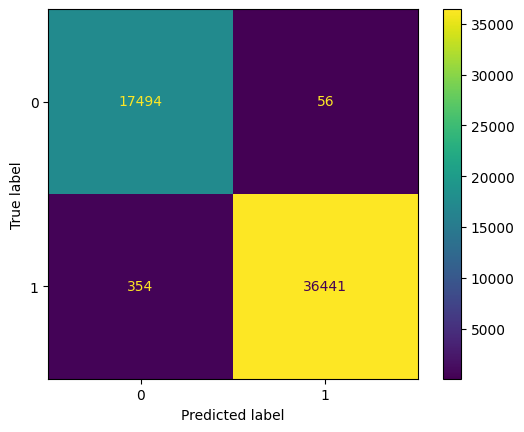

In [18]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
print(flat_predictions)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)
print(flat_true_labels)
#true_exp = [i[1] for i in flat_true_labels]
true_exp = [1 if i == True else 0 for i in flat_true_labels]
#print(true_exp)

from sklearn.metrics import f1_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the F1
f1 = f1_score(true_exp, flat_predictions)

print('F1 Score: %.3f' % f1)
print("Accuracy:", accuracy_score(true_exp, flat_predictions))

ConfusionMatrixDisplay.from_predictions(true_exp, flat_predictions)
plt.show()

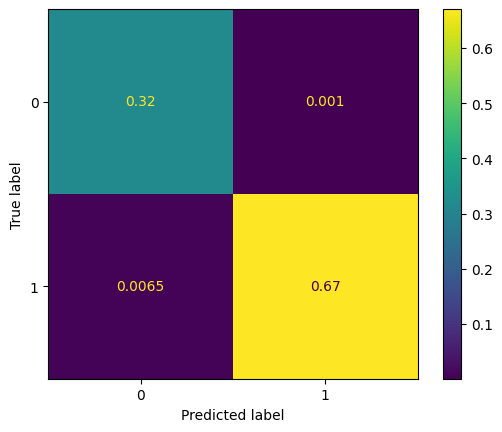

In [30]:
ConfusionMatrixDisplay.from_predictions(true_exp, flat_predictions, normalize='all')
plt.show()

In [42]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

print("Confusion matrix:")
print(confusion_matrix(true_exp, flat_predictions))

print("Accuracy:", accuracy_score(true_exp, flat_predictions))
inequality_ixs = np.not_equal(true_exp, flat_predictions)
print(len(np.array(true_exp)[inequality_ixs]))
test_dataset[inequality_ixs]
incorrect_text = np.array(sen_w_feats)[test_ix][inequality_ixs]
# print(incorrect_text)
# print(len(incorrect_text))
# print(np.array(sen_w_feats)[test_ix])
# X_train_val['lang'].value_counts()
print()

Confusion matrix:
[[18059    80]
 [ 1003 39232]]
Accuracy: 0.9814472196525851
1083
["I created this Tweet at 2018-07-23T04:00:55.000Z o'clock in the ja language and in 東京、神奈川 from twittbot.net. My name is Who's the next one ?, username is wtno_group and I am not verified. I would describe myself as 東京、神奈川で定期的にイベント開催しているグループです！ジャンル問わず様々な内容でやっていきますので気になった方はフォローお願いします！ 連絡先 wtno.group@gmail.com. I wrote: ダーツイベント開催します☆\n日時：１２月５日（土）\u3000１３：００～\n場所：新宿\n参加費：５００円\n人数：５～８人\u3000運営参加３人\n応募：LINE@  arkc0re\n      wtno.group@  https://t.co/xW0oeMQE6T\n\u3000\u3000\u3000またはTwitterリプまで☻ "
 "I created this Tweet at 2018-07-17T23:04:28.000Z o'clock in the en language and in Provo, Utah, USA from Tweetbot for Mac. My name is Richard K Miller, username is richardkmiller and I am not verified. I would describe myself as Founder @goldiemayapp, genealogy power tools. I wrote: Moving off of Gmail is really two steps: leaving the domain (https://t.co/0fR6itQzPU) and leaving the service. You can leave the doma

en     147752
ja       5634
es       1189
qme       763
zxx       555
in        528
und       381
fr        321
pt        276
de        189
ca        180
qht       176
ar        147
hi        147
tl        139
it        137
nl         97
ro         92
ko         87
vi         67
qam        56
th         54
tr         53
cs         48
ru         45
et         43
fa         32
ht         28
da         28
sv         24
pl         24
te         24
fi         19
zh         19
ta         18
hu         17
el         14
qst        14
cy         12
no         12
ur         10
art         5
eu          4
lv          4
sl          4
bn          4
lt          3
mr          2
iw          2
ne          2
kn          2
or          1
my          1
is          1
bg          1
uk          1
Name: lang, dtype: int64

In [21]:
saved = pd.DataFrame({'true': true_exp, 'preds': flat_predictions})
saved.to_csv("predictions.csv")

In [49]:
all_test_text = np.array(sen_w_feats)[test_ix]
with open("test_text.txt", 'w', encoding="utf-8") as f:
    f.write(str(all_test_text))

In [52]:
#np.savetxt('test_text.csv', all_test_text, delimiter=',', fmt='%s')
pd.DataFrame({'test_text': all_test_text}).to_csv("all_test_text.csv")

Accuracy: 0.9814472196525851
[[18059    80]
 [ 1003 39232]]
1083


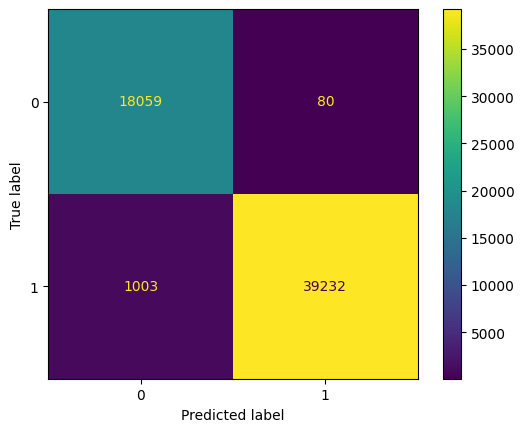

In [11]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

evaluation = pd.read_csv("predictions.csv")
test_text = pd.read_csv("all_test_text.csv")

print("Accuracy:", accuracy_score(evaluation['true'], evaluation['preds']))

inequality_ixs = np.not_equal(evaluation['true'], evaluation['preds'])
print(confusion_matrix(evaluation['true'], evaluation['preds']))
print(len(np.array(test_text)[inequality_ixs]))
#test_text[inequality_ixs]
ConfusionMatrixDisplay.from_predictions(evaluation['true'], evaluation['preds'])
plt.show()

In [1]:
print()

In [13]:
pd.DataFrame(evaluation['true']).value_counts()

true
1       40235
0       18139
dtype: int64

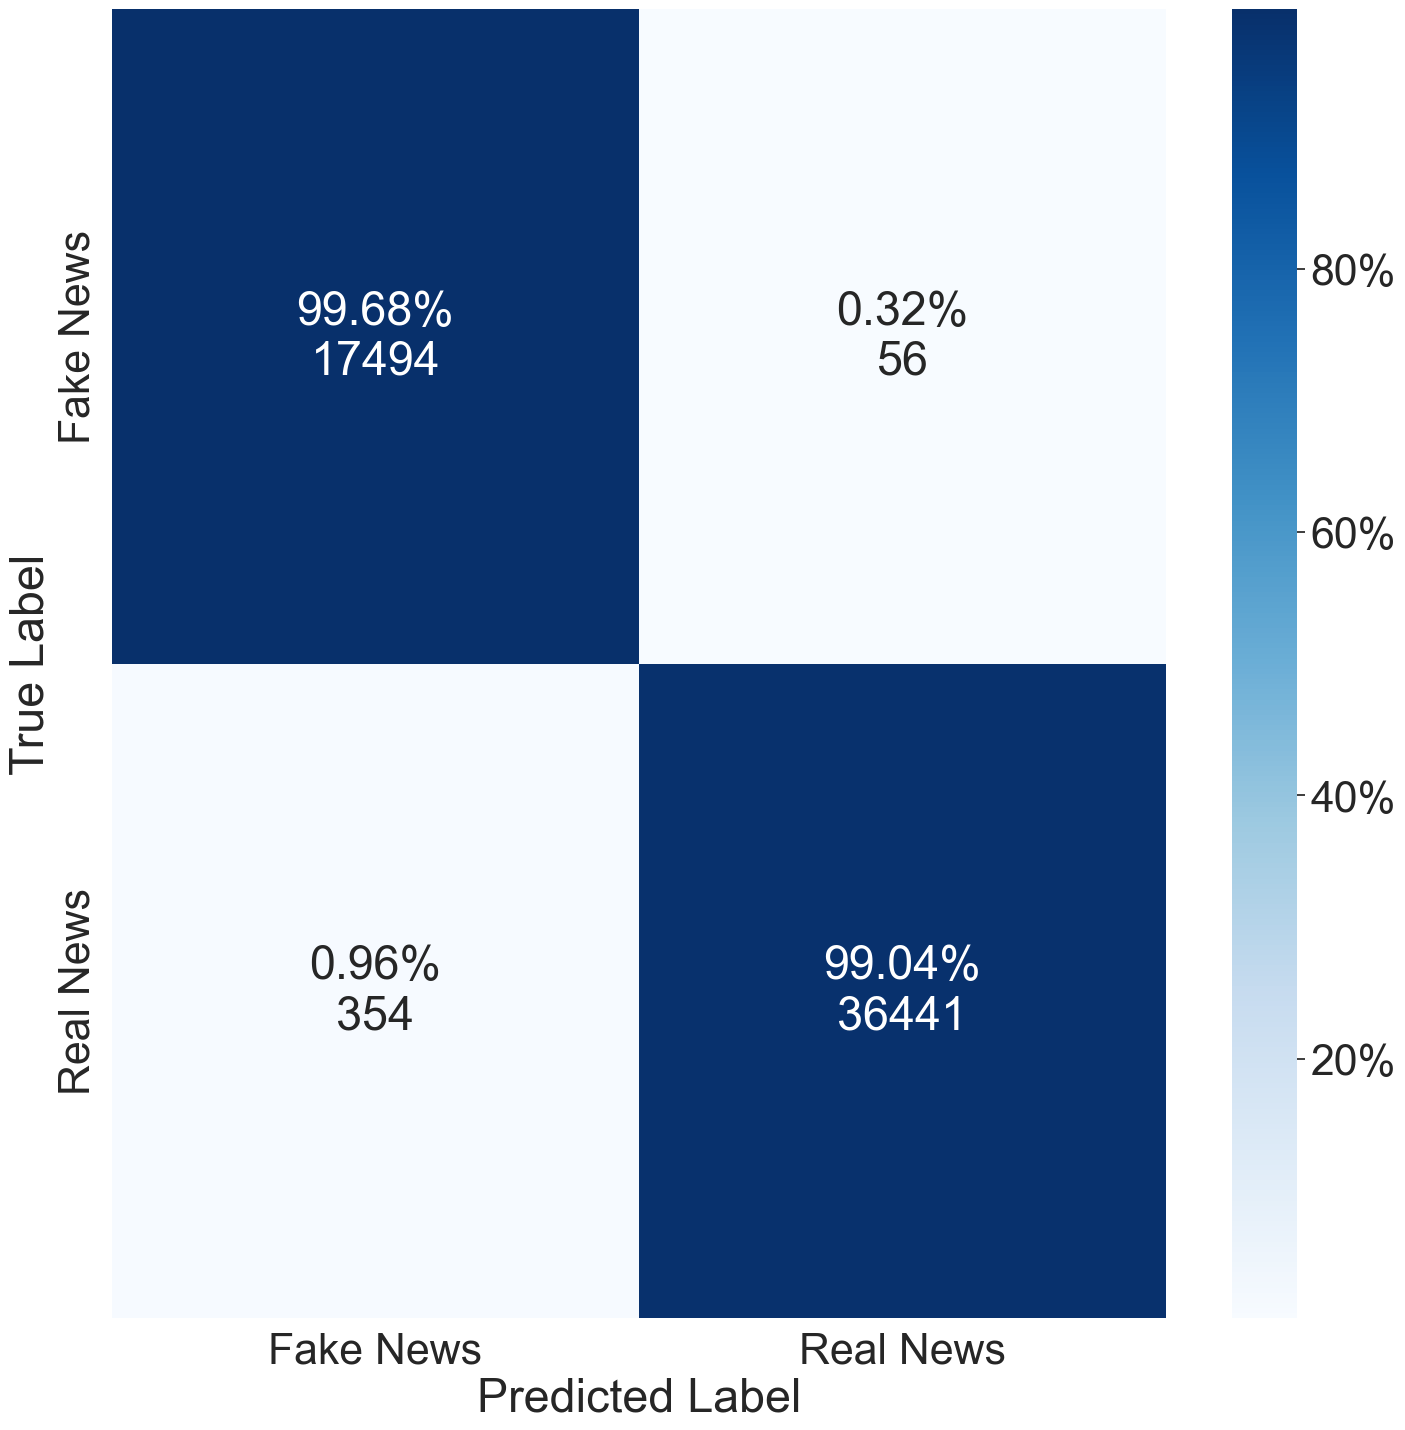

In [22]:
# Retrieved from https://gist.github.com/mesquita/f6beffcc2579c6f3a97c9d93e278a9f1

from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    plt.savefig(filename,  bbox_inches='tight')

y_true = true_exp
y_pred = flat_predictions

cm_analysis(y_true, y_pred, "conf.png", [0, 1], ["Fake News", "Real News"])